# TP PLAGIO

## Librerias:

In [1]:
import docx2txt
import pdftotext
import filetype
import os
import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk import re
from nltk.corpus import stopwords
import nltk.stem
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

## Funciones

In [2]:
def pdf_a_txt(pdf):
    with open(pdf, "rb") as f:
        pdf_convertido = pdftotext.PDF(f)
        txt = ("\n\n".join(pdf_convertido))
        return txt
            
def doc_a_txt(docx):
    return (docx2txt.process(docx))

def conversion_de_archivo(ruta_de_archivo):
    kind = filetype.guess(ruta_de_archivo)
    tipo = kind.extension
    if(tipo == "pdf"):
       return pdf_a_txt(ruta_de_archivo)
    else:
       return doc_a_txt(ruta_de_archivo)

def remover_stopwords(texto):
    return [word for word in texto if word not in stopwords.words('spanish')]

def procesar_archivos(ruta_arch,ruta_arch2):
    print("El archivo con el que se lo compara es:")
    print(os.path.basename(ruta_arch2)+'\n')
    archivo = conversion_de_archivo(ruta_arch)
    archivo2 = conversion_de_archivo(ruta_arch2)
    archivo_tok = word_tokenize(archivo)
    archivo2_tok = word_tokenize(archivo2)
    archivo_sent=sent_tokenize(archivo)
    archivo2_sent=sent_tokenize(archivo2)
    archivo_tokenizado = [word.lower() for word in archivo_tok if re.search("\w",word)]
    archivo2_tokenizado = [word.lower() for word in archivo2_tok if re.search("\w",word)]
    archivo_tok_sin_stops = remover_stopwords(archivo_tokenizado)
    archivo2_tok_sin_stops = remover_stopwords(archivo2_tokenizado)
    #print(taggear(archivo_tok_sin_stops))
    list_de_score = comparacion_con_trigramas(archivo_tok_sin_stops,archivo2_tok_sin_stops)
    print("Comparacion por lcs:")
    score_lcs = comparacion_por_longest_common_subsequence(archivo,archivo2)
    print('\n'+'\n')
    graficar(list_de_score[0],list_de_score[1],score_lcs)
    if ruta_arch not in lista_de_archivos:
        guardar_archivo(ruta_arch)
    
def lemattizar(archivo):
    stemmer = nltk.stem.SnowballStemmer('spanish')
    stem_vectorizer = StemmedCountVectorizer(min_df=1, stop_words='spanish')
    stem_analyze = stem_vectorizer.build_analyzer()
    Y = stem_analyze(archivo)
    for tok in Y:
        print(tok)
    
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))
    
def taggear(archivo_tok):
    archivo_taggeado = nltk.pos_tag(archivo_tok)
    return archivo_taggeado
    
def comparacion_con_trigramas(arch1,arch2):
    s = 0
    trigrams_arch1 = []
    for i in range(len(arch1)-2):
        t=(arch1[i],arch1[i+1],arch1[i+2])
        trigrams_arch1.append(t)

    trigrams_arch2 = []
    for i in range(len(arch2)-2):
        t=(arch2[i],arch2[i+1],arch2[i+2])
        trigrams_arch2.append(t)
        if t in trigrams_arch1:
            s+=1
    #print(s)
    print("Comparacion por jaccard:")
    score_jaccard = comparacion_por_jaccard(s,trigrams_arch1,trigrams_arch2)
    print("Comparacion por containment measure:")
    score_containment = comparacion_por_containment_measure(s,trigrams_arch2)
    return [score_containment,score_jaccard]
    
def comparacion_por_jaccard(s,trigrams_arch1,trigrams_arch2):
    jaccard_coefficient = s/(len(trigrams_arch1)+len(trigrams_arch2))
    print(jaccard_coefficient)
    medidor_de_comparacion(jaccard_coefficient)
    print('\n')
    return(jaccard_coefficient)

def comparacion_por_containment_measure(s,trigrams_arch2):
    containment = s/len(trigrams_arch2)
    print(containment)
    medidor_de_comparacion(containment)
    print('\n')
    return(containment)

def lcs(l1,l2):
    s1=word_tokenize(l1)
    s2=word_tokenize(l2)
    # storing the dp values 
    dp = [[None]*(len(s1)+1) for i in range(len(s2)+1)] 
  
    for i in range(len(s2)+1): 
        for j in range(len(s1)+1): 
            if i == 0 or j == 0: 
                dp[i][j] = 0
            elif s2[i-1] == s1[j-1]: 
                dp[i][j] = dp[i-1][j-1]+1
            else: 
                dp[i][j] = max(dp[i-1][j] , dp[i][j-1]) 
    return dp[len(s2)][len(s1)] 

def comparacion_por_longest_common_subsequence(arch1,arch2):
    sent_o = sent_tokenize(arch1)
    sent_p = sent_tokenize(arch2)
    tokens_p = word_tokenize(arch2)

    #maximum length of LCS for a sentence in suspicious text
    max_lcs=0
    sum_lcs=0

    for i in sent_p:
        for j in sent_o:
            l=lcs(i,j)
            max_lcs=max(max_lcs,l)
        sum_lcs+=max_lcs
        max_lcs=0

    score=sum_lcs/len(tokens_p)
    print(score)
    medidor_de_comparacion(score)
    print('\n')
    return(score)

def guardar_archivo(ruta_archivo):
    lista_de_archivos.append(ruta_archivo)
    

def procesar_archivo(ruta_archivo):
    print("El nombre del archivo a procesar es:")
    print(os.path.basename(ruta_archivo)+'\n')
    for a in lista_de_archivos:
        if(a != ruta_archivo):
            procesar_archivos(ruta_archivo,a)
    
def medidor_de_comparacion(score):
    if score <= 0.2:
        print("no existe plagio")
    elif 0.2 <= score and score <= 0.4:
        print("Poca probabilidad de plagio")
    elif 0.4 <= score and score <= 0.6:
        print("Ligera probabilidad de plagio")
    elif score >= 0.6:
        print("Alta probabilidad de plagio")
        
def graficar(score_containment,score_jaccard,score_lcs):
    objects = ('score_containment','score jaccard','score lcs')
    y_pos = np.arange(len(objects))
    performance = [score_containment,score_jaccard,score_lcs]
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Score')
    plt.title('Metodos de medición')

    plt.show()
    

El nombre del archivo a procesar es:
Economia de experiencia.pdf

El archivo con el que se lo compara es:
Marketing - TP 0.docx

Comparacion por jaccard:
0.0015037593984962407
no existe plagio


Comparacion por containment measure:
0.004347826086956522
no existe plagio


Comparacion por lcs:
0.20464135021097046
Poca probabilidad de plagio







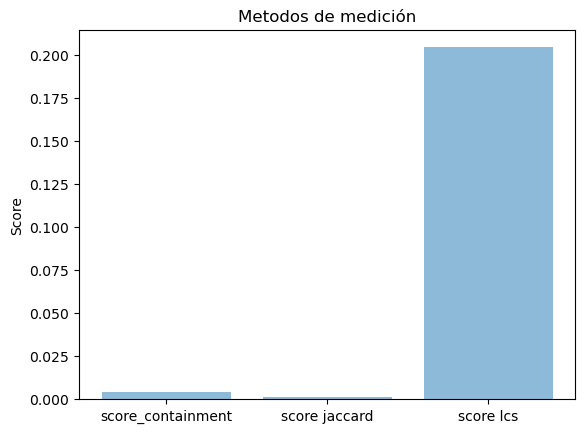

El archivo con el que se lo compara es:
Economia de experiencia (1).pdf

Comparacion por jaccard:
0.5
Ligera probabilidad de plagio


Comparacion por containment measure:
1.0
Alta probabilidad de plagio


Comparacion por lcs:
1.0
Alta probabilidad de plagio







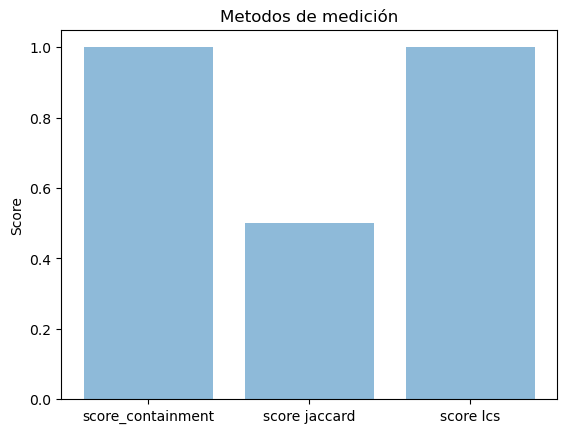

El archivo con el que se lo compara es:
K5071 - Matias David Choren - TP N°5 Rifkin (1).pdf

Comparacion por jaccard:
0.0009216589861751152
no existe plagio


Comparacion por containment measure:
0.0015384615384615385
no existe plagio


Comparacion por lcs:
0.24244771494965142
Poca probabilidad de plagio







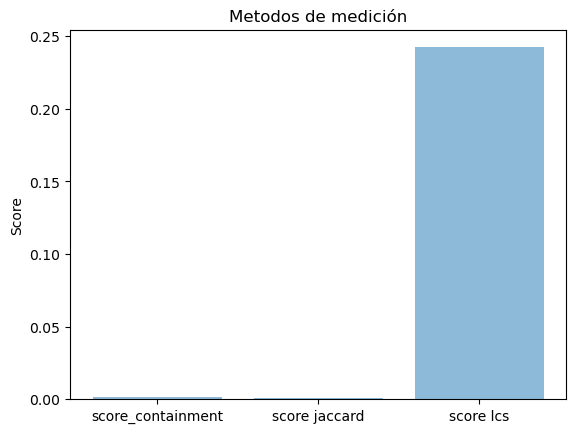

El archivo con el que se lo compara es:
Marketing - TP 1.docx

Comparacion por jaccard:
0.0011135857461024498
no existe plagio


Comparacion por containment measure:
0.0021598272138228943
no existe plagio


Comparacion por lcs:
0.23529411764705882
Poca probabilidad de plagio







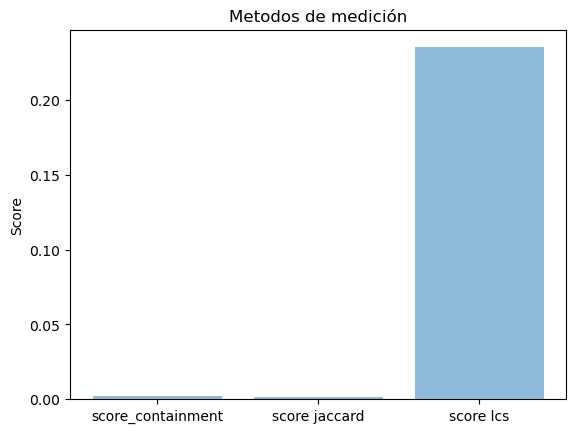

El archivo con el que se lo compara es:
Marketing - TP 2.docx

Comparacion por jaccard:
0.001002004008016032
no existe plagio


Comparacion por containment measure:
0.0017761989342806395
no existe plagio


Comparacion por lcs:
0.2588916459884202
Poca probabilidad de plagio







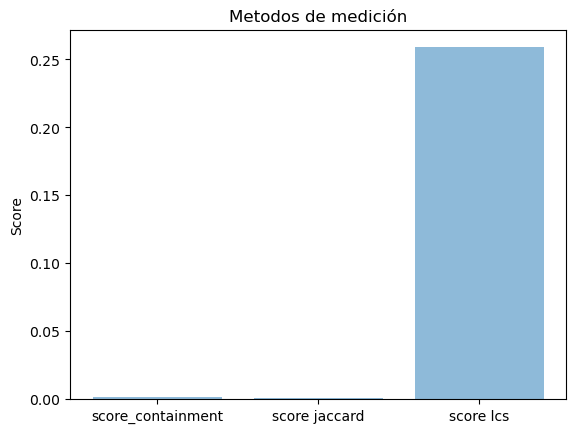

In [3]:
global lista_de_archivos
lista_de_archivos = []
ruta_archivo = '/Users/Usuario/Desktop/dataset/Marketing - TP 0.docx'
ruta_archivo2 = '/Users/Usuario/Desktop/dataset/Economia de experiencia.pdf'
ruta_archivo3 = '/Users/Usuario/Desktop/dataset/Economia de experiencia (1).pdf'
ruta_archivo4 = '/Users/Usuario/Desktop/dataset/K5071 - Matias David Choren - TP N°5 Rifkin (1).pdf'
ruta_archivo5 = '/Users/Usuario/Desktop/dataset/Marketing - TP 1.docx'
ruta_archivo6 = '/Users/Usuario/Desktop/dataset/Marketing - TP 2.docx'
guardar_archivo(ruta_archivo)
guardar_archivo(ruta_archivo2)
guardar_archivo(ruta_archivo3)
guardar_archivo(ruta_archivo4)
guardar_archivo(ruta_archivo5)
guardar_archivo(ruta_archivo6)
#procesar_archivos(ruta_archivo2,ruta_archivo3)
procesar_archivo(ruta_archivo2)

